In [1]:
#####################
# IMPORT LIBS
#####################

import lightgbm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
import wandb
import datetime
import os
import random
import joblib
import shutil

from sklearn.cluster import KMeans
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from scoring import local_scorer
import scipy

from lightgbm import LGBMClassifier, LGBMRegressor


#####################
# SET CONSTANTS
#####################

INPUT_PATH = Path('../input')
OUTPUT_PATH = Path('../output')
TRAIN_PATH = INPUT_PATH 

TARGET_COLUMNS = ['sale_flg', 'sale_amount', 'contacts']
FIXED_SEEDS = [948, 534, 432, 597, 103, 21, 2242, 17, 20, 29]

RANDOM_SEED = 4444
USE_WANDB = False
CURRENT_TIME = str(datetime.datetime.now()).replace(' ', '_').split('.')[0]

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(RANDOM_SEED)

In [2]:
###############
# Config
###############

n_seed = 10
n_fold = 3
make_submission = False

In [3]:
if USE_WANDB:
    wandb.login()
    run = wandb.init(project="idao-2021-finals", name = f'{CURRENT_TIME}') # todo add config here

In [4]:
%%time

transactions = pd.read_csv(INPUT_PATH / 'trxn.csv')
assets_under_management = pd.read_csv(INPUT_PATH / 'aum.csv')
balance = pd.read_csv(INPUT_PATH / 'balance.csv')
client = pd.read_csv(INPUT_PATH / 'client.csv')
campaigns = pd.read_csv(INPUT_PATH / 'com.csv')
deals = pd.read_csv(INPUT_PATH / 'deals.csv')
dict_merchant_category_code = pd.read_csv(INPUT_PATH / 'dict_mcc.csv')
payments = pd.read_csv(INPUT_PATH / 'payments.csv')
funnel = pd.read_csv(INPUT_PATH / 'funnel.csv')
appl = pd.read_csv(INPUT_PATH / 'appl.csv')

/opt/conda/lib/python3.7/site-packages/decorator.py:231: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  return caller(func, *(extras + args), **kw)


CPU times: user 7.18 s, sys: 605 ms, total: 7.79 s
Wall time: 7.78 s


## Data prep

In [5]:
transactions['mcc_cd'] = transactions['mcc_cd'].fillna(-2)
transactions['txn_city'] = transactions['txn_city'].fillna('<UNK>')
transactions['tsp_name'] = transactions['tsp_name'].fillna('<UNK>')
transactions['txn_comment_2'] = transactions['txn_comment_2'].fillna('<UNK>')

transactions = transactions.merge(dict_merchant_category_code, on='mcc_cd', how='left')
transactions['brs_mcc_group'] = transactions['brs_mcc_group'].fillna('<UNK>')
transactions['brs_mcc_subgroup'] = transactions['brs_mcc_subgroup'].fillna('<UNK>')

balance['crncy_cd'] = balance['crncy_cd'].fillna(-2)
balance['prod_cat_name'] = balance['prod_cat_name'].fillna('<UNK>')
balance['prod_group_name'] = balance['prod_group_name'].fillna('<UNK>')

client = client.rename(columns={
    'gender': 'client_gender',
    'age': 'client_age',
    'region': 'client_region',
    'city': 'client_city',
    'citizenship': 'client_citizenship',
    'education': 'client_education',
    'job_type': 'client_job_type'
})

campaigns['prod'] = campaigns['prod'].fillna('<UNK>')

deals['crncy_cd'] = deals['crncy_cd'].fillna(-2)
deals['agrmnt_rate_active'] = deals['agrmnt_rate_active'].fillna(-2)
deals['agrmnt_rate_passive'] = deals['agrmnt_rate_passive'].fillna(-2)
deals['agrmnt_sum_rur'] = deals['agrmnt_sum_rur'].fillna(-2)
deals['prod_type_name'] = deals['prod_type_name'].fillna('<UNK>')
deals['argmnt_close_start_days'] = (pd.to_datetime(deals['agrmnt_close_dt']) - pd.to_datetime(deals['agrmnt_start_dt'])).dt.days.fillna(-2)

payments['day_dt'] = pd.to_datetime(payments['day_dt'])

appl['appl_stts_name_dc'] = appl['appl_stts_name_dc'].fillna('<UNK>')
appl['appl_sale_channel_name'] = appl['appl_sale_channel_name'].fillna('<UNK>')
appl['month_end_dt'] = pd.to_datetime(appl['month_end_dt'])

In [6]:
def get_feature_total(df, col_name):
    return data['client_id'].map(df.groupby(['client_id', col_name]).size().index.get_level_values('client_id').value_counts()).fillna(0)


def get_feature_most_common(df, col_name, fill_na_value):
    return data['client_id'].map(df.groupby('client_id')[col_name].agg(lambda x: scipy.stats.mode(x)[0][0])).fillna(fill_na_value)


def get_feature_max(df, col_name, fill_na_value):
    return data['client_id'].map(df.groupby('client_id')[col_name].max()).fillna(fill_na_value)


def get_feature_min(df, col_name, fill_na_value):
    return data['client_id'].map(df.groupby('client_id')[col_name].min()).fillna(fill_na_value)


def get_feature_mean(df, col_name, fill_na_value):
    return data['client_id'].map(df.groupby('client_id')[col_name].mean()).fillna(fill_na_value)


def get_feature_std(df, col_name, fill_na_value):
    return data['client_id'].map(df.groupby('client_id')[col_name].std()).fillna(fill_na_value)


def get_feature_max_min(df, col_name, fill_na_value):
    return data['client_id'].map(df.groupby('client_id')[col_name].agg(lambda x: x.max() - x.min())).fillna(fill_na_value)


def get_feature_timedelta(df, col_name):
    return data['client_id'].map(df.groupby('client_id')[col_name].agg(lambda x: (x.max() - x.min()).days)).fillna(-1)


def create_features_transactions(data):
    
    data = data.copy()
    
    # transaction features
    data['total_transactions'] = data['client_id'].map(transactions.groupby('client_id').size()).fillna(0)
    data['total_cards'] = get_feature_total(transactions, 'card_id')

#     data['total_transaction_amount'] = data['client_id'].map(transactions.groupby('client_id')['tran_amt_rur'].sum()).fillna(0) # add monthly, daily, etc
    data['mean_transaction_amt'] = get_feature_mean(transactions, 'tran_amt_rur', -1) # add monthly, daily, etc
    data['std_transaction_amount'] = get_feature_std(transactions, 'tran_amt_rur', -1) # add monthly, daily, etc
    
    data['total_mcc_cd'] = get_feature_total(transactions, 'mcc_cd')
    data['total_share_mcc_cd'] = (data['total_mcc_cd'] / data['total_transactions']).fillna(0)
    data['most_common_mcc_cd'] = get_feature_most_common(transactions, 'mcc_cd', -1)
    
    data['total_merchant_cd'] = get_feature_total(transactions, 'merchant_cd')
    data['total_share_merchant_cd'] = (data['total_merchant_cd'] / data['total_transactions']).fillna(0)
    data['most_common_merchant_cd'] = get_feature_most_common(transactions, 'merchant_cd', -1)
    
    data['total_txn_city'] = get_feature_total(transactions, 'txn_city')
    data['total_share_txn_city'] = (data['total_txn_city'] / data['total_transactions']).fillna(0)
    data['most_common_txn_city'] = get_feature_most_common(transactions, 'txn_city', '<unknown>')
    
    data['total_tsp_name'] = get_feature_total(transactions, 'tsp_name')
    data['total_share_tsp_name'] = (data['total_tsp_name'] / data['total_transactions']).fillna(0)
    data['most_common_tsp_name'] = get_feature_most_common(transactions, 'tsp_name', '<unknown>')
    
    data['total_txn_comment_1'] = get_feature_total(transactions, 'txn_comment_1')
    data['most_common_txn_comment_1'] = get_feature_most_common(transactions, 'txn_comment_1', '<unknown>')
    
    data['total_txn_comment_2'] = get_feature_total(transactions, 'txn_comment_2')
    data['most_common_txn_comment_2'] = get_feature_most_common(transactions, 'txn_comment_2', '<unknown>')
    
    data['total_brs_mcc_group'] = get_feature_total(transactions, 'brs_mcc_group')
    data['most_common_brs_mcc_group'] = get_feature_most_common(transactions, 'brs_mcc_group', '<unknown>')
    
    data['total_brs_mcc_subgroup'] = get_feature_total(transactions, 'brs_mcc_subgroup')
    data['most_common_brs_mcc_subgroup'] = get_feature_most_common(transactions, 'brs_mcc_subgroup', '<unknown>')
    
    return data


def create_features_aum(data):
    data = data.copy()
    
    data['total_aum'] = data['client_id'].map(assets_under_management.groupby('client_id').size()).fillna(0)
    
    data['total_product_code'] = get_feature_total(assets_under_management, 'product_code')
    data['most_common_product_code'] = get_feature_most_common(assets_under_management, 'product_code', '<unknown>').value_counts()
    
    data['mean_balance_rur_amt'] = get_feature_mean(assets_under_management, 'balance_rur_amt', -1)
    data['std_balance_rur_amt'] = get_feature_std(assets_under_management, 'balance_rur_amt', -1)
    data['max_min_balance_rur_amt'] = get_feature_max_min(assets_under_management, 'balance_rur_amt', -1)
    
    return data


def create_features_balance(data):
    data = data.copy()
    
    data['total_balance'] = data['client_id'].map(balance.groupby('client_id').size()).fillna(0)
    
    data['total_balance_crncy_cd'] = get_feature_total(balance, 'crncy_cd')
    data['most_common_balance_crncy_cd'] = get_feature_most_common(balance, 'crncy_cd', -1)
    
    data['total_eop_bal_sum_rur'] = get_feature_total(balance, 'eop_bal_sum_rur')
    data['total_share_eop_bal_sum_rur'] = (data['total_eop_bal_sum_rur'] / data['total_balance']).fillna(0)
    data['mean_eop_bal_sum_rur'] = get_feature_mean(balance, 'eop_bal_sum_rur', -9999)
    data['std_eop_bal_sum_rur'] = get_feature_std(balance, 'eop_bal_sum_rur', -9999)
    
    data['total_min_bal_sum_rur'] = get_feature_total(balance, 'min_bal_sum_rur')
    data['total_share_min_bal_sum_rur'] = (data['total_min_bal_sum_rur'] / data['total_balance']).fillna(0)
    data['mean_min_bal_sum_rur'] = get_feature_mean(balance, 'min_bal_sum_rur', -9999)
    data['std_min_bal_sum_rur'] = get_feature_std(balance, 'min_bal_sum_rur', -9999)
    
    data['total_max_bal_sum_rur'] = get_feature_total(balance, 'max_bal_sum_rur')
    data['total_share_max_bal_sum_rur'] = (data['total_max_bal_sum_rur'] / data['total_balance']).fillna(0)
    data['mean_max_bal_sum_rur'] = get_feature_mean(balance, 'max_bal_sum_rur', -9999)
    data['std_max_bal_sum_rur'] = get_feature_std(balance, 'max_bal_sum_rur', -9999)
    
    data['total_avg_bal_sum_rur'] = get_feature_total(balance, 'avg_bal_sum_rur')
    data['total_share_avg_bal_sum_rur'] = (data['total_avg_bal_sum_rur'] / data['total_balance']).fillna(0)
    data['mean_avg_bal_sum_rur'] = get_feature_mean(balance, 'avg_bal_sum_rur', -9999)
    data['std_avg_bal_sum_rur'] = get_feature_std(balance, 'avg_bal_sum_rur', -9999)
    data['max_min_avg_bal_sum_rur'] = get_feature_max_min(balance, 'avg_bal_sum_rur', -9999)
    
    data['total_prod_cat_name'] = get_feature_total(balance, 'prod_cat_name')
    data['most_common_prod_cat_name'] = get_feature_most_common(balance, 'prod_cat_name', '<unknown>')
    
    data['total_prod_group_name'] = get_feature_total(balance, 'prod_group_name')
    data['most_common_prod_group_name'] = get_feature_most_common(balance, 'prod_group_name', '<unknown>')
    
    return data


def create_features_client(data):
    data = data.copy()
    
    data = data.merge(client, on='client_id')
    data['match_client_region-region_cd'] = (data['client_region'] == data['region_cd']).astype(int)
    data.drop('client_citizenship', axis=1)
    
    return data


def create_features_campaigns(data):
    data = data.copy()
    
    data['total_campaigns'] = data['client_id'].map(campaigns.groupby('client_id').size()).fillna(0)
    
    data['total_agr_flg'] = get_feature_total(campaigns, 'agr_flg')
    data['mean_agr_flg'] = get_feature_mean(campaigns, 'agr_flg', -1)
    
    data['total_otkaz'] = get_feature_total(campaigns, 'otkaz')
    data['mean_otkaz'] = get_feature_mean(campaigns, 'otkaz', -1)
    
    data['total_dumaet'] = get_feature_total(campaigns, 'dumaet')
    data['mean_dumaet'] = get_feature_mean(campaigns, 'dumaet', -1)
    
    data['total_ring_up_flg'] = get_feature_total(campaigns, 'ring_up_flg')
    data['most_common_ring_up_flg'] = get_feature_most_common(campaigns, 'ring_up_flg', -1)
    
    data['total_count_comm'] = get_feature_total(campaigns, 'count_comm')
    data['most_common_count_comm'] = get_feature_most_common(campaigns, 'count_comm', -1)
    
    data['total_channel'] = get_feature_total(campaigns, 'channel')
    data['most_common_channel'] = get_feature_most_common(campaigns, 'channel', '<unknown>')
    
    data['total_prod'] = get_feature_total(campaigns, 'prod')
    data['most_common_prod'] = get_feature_most_common(campaigns, 'prod', '<unknown>')
    
    return data


def create_features_deals(data):
    data = data.copy()
    
    data['total_deals'] = data['client_id'].map(deals.groupby('client_id').size()).fillna(0)
    
    data['total_deals_crncy_cd'] = get_feature_total(deals, 'crncy_cd')
    data['most_common_deals_crncy_cd'] = get_feature_most_common(deals, 'crncy_cd', -1)
    
    data['total_agrmnt_rate_active'] = get_feature_total(deals, 'agrmnt_rate_active')
    data['max_agrmnt_rate_active'] = get_feature_max(deals, 'agrmnt_rate_active', -1)
    
    data['total_agrmnt_rate_passive'] = get_feature_total(deals, 'agrmnt_rate_passive')
    data['max_agrmnt_rate_passive'] = get_feature_max(deals, 'agrmnt_rate_passive', -1)
    
    data['total_agrmnt_sum_rur'] = get_feature_total(deals, 'agrmnt_sum_rur')
    data['mean_agrmnt_sum_rur'] = get_feature_mean(deals, 'agrmnt_sum_rur', -1)
    data['std_agrmnt_sum_rur'] = get_feature_std(deals, 'agrmnt_sum_rur', -1)
    
    data['total_prod_type_name'] = get_feature_total(deals, 'prod_type_name')
    data['most_common_prod_type_name'] = get_feature_most_common(deals, 'prod_type_name', '<unknown>')
    
    data['total_argmnt_close_start_days'] = get_feature_total(deals, 'argmnt_close_start_days')
    data['max_argmnt_close_start_days'] = get_feature_max(deals, 'argmnt_close_start_days', -1)
    data['min_argmnt_close_start_days'] = get_feature_min(deals, 'argmnt_close_start_days', -1)
    data['mean_argmnt_close_start_days'] = get_feature_mean(deals, 'argmnt_close_start_days', -1)
    data['std_argmnt_close_start_days'] = get_feature_std(deals, 'argmnt_close_start_days', -1)
    
    return data


def create_features_payments(data):
    data = data.copy()
    
    data['total_payments'] = data['client_id'].map(payments.groupby('client_id').size()).fillna(0)
    
    data['mean_payments_sum_rur'] = get_feature_mean(payments, 'sum_rur', -1)
    data['std_payments_sum_rur'] = get_feature_std(payments, 'sum_rur', -1)
    data['min_payments_sum_rur'] = get_feature_min(payments, 'sum_rur', -1)
    data['max_payments_sum_rur'] = get_feature_max(payments, 'sum_rur', -1)
    
    data['total_pmnts_name'] = get_feature_total(payments, 'pmnts_name')
    data['most_common_pmnts_name'] = get_feature_most_common(payments, 'pmnts_name', '<unknown>')
    
    # payments 
#     data['last_known_salary'] = data['client_id'].map(payments.groupby('client_id').apply(lambda x: x['sum_rur'].iloc[0])).fillna(-1)
#     data['total_recieved_salary'] = data['client_id'].map(payments.groupby('client_id').apply(lambda x: x['sum_rur'].sum())).fillna(-1)
    
    data['timedelta_payments_day_dt'] = get_feature_timedelta(payments, 'day_dt')
    
    return data


def create_features_appl(data):
    data = data.copy()
    
    data['total_appl'] = data['client_id'].map(appl.groupby('client_id').size()).fillna(0)
    
    data['total_appl_prod_group_name'] = get_feature_total(appl, 'appl_prod_group_name')
    data['most_common_appl_prod_group_name'] = get_feature_most_common(appl, 'appl_prod_group_name', '<unknown>')
    
    data['total_appl_prod_type_name'] = get_feature_total(appl, 'appl_prod_type_name')
    data['most_common_appl_prod_type_name'] = get_feature_most_common(appl, 'appl_prod_type_name', '<unknown>')
    
    data['total_appl_stts_name_dc'] = get_feature_total(appl, 'appl_stts_name_dc')
    data['most_common_appl_stts_name_dc'] = get_feature_most_common(appl, 'appl_stts_name_dc', '<unknown>')
    
    data['total_appl_sale_channel_name'] = get_feature_total(appl, 'appl_sale_channel_name')
    data['most_common_appl_sale_channel_name'] = get_feature_most_common(appl, 'appl_sale_channel_name', '<unknown>')
    
    data['timedelta_appl_month_end_dt'] = get_feature_timedelta(appl, 'month_end_dt')
    
    return data


def create_features_funnel(data):
    data = data.copy()
    
    return data

In [7]:
%%time
# create features

data = funnel.copy()

data = create_features_transactions(data)
data = create_features_aum(data)
data = create_features_balance(data)
data = create_features_client(data)
data = create_features_campaigns(data)
data = create_features_deals(data)
data = create_features_payments(data)
data = create_features_appl(data)
data = create_features_funnel(data)

CPU times: user 1min 10s, sys: 34.7 ms, total: 1min 10s
Wall time: 1min 10s


In [8]:
data.shape

(21498, 128)

In [9]:
try:
    os.mkdir(OUTPUT_PATH / 'preprocessors')
except:
    shutil.rmtree(OUTPUT_PATH / 'preprocessors')
    os.mkdir(OUTPUT_PATH / 'preprocessors')

In [10]:
# data encode

for c in data.columns:
    col_type = data[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        data[c] = data[c].astype('category')

In [11]:
TARGET_COLUMNS =  ['sale_flg', 'sale_amount', 'contacts']

In [12]:
X = data.drop(columns = TARGET_COLUMNS + ['client_id'])
Y = data[TARGET_COLUMNS[0]]

## Train

In [13]:
try:
    os.mkdir(OUTPUT_PATH / 'models')
except:
    shutil.rmtree(OUTPUT_PATH / 'models')
    os.mkdir(OUTPUT_PATH / 'models')

In [14]:
learning_rate = 0.5
num_leaves = 50
min_data_in_leaf = 1000
feature_fraction = 0.9
num_boost_round = 3000

In [15]:
def running_train(X_train, Y_train, X_val, Y_val, i_fold=None, seed=None, params = None):
    # prepare for train
    params = {
# #           "objective": "cross_entropy",
#           "num_leaves": 256,
#            "max_bin": 128,
#           "feature_fraction": feature_fraction,
#           "min_child_samples": 5,
#           "min_child_weight": 50,
#           "min_split_gain": 0.1,
#           "subsample": 0.7,
          'n_jobs': -1,
          'random_state': seed
          }
    
    params['random_state'] = seed
    
    
    model = LGBMClassifier(**params) # define model here
    
    # Fit and save model
    
    if X_val is None:
        model.fit(X_train, Y_train, verbose=False)
    else:
        model.fit(X_train, Y_train,   eval_set=(X_val, Y_val), early_stopping_rounds=500, verbose=False)
    joblib.dump(model, OUTPUT_PATH / 'models' / f'lightgbm_{i_fold}_{seed}_{CURRENT_TIME}.pkl')

In [18]:
oof = np.zeros((X.shape[0], n_seed)) # cv_score
seeds = []
for i_seed in range(n_seed):
    seed = FIXED_SEEDS[i_seed]
    seed_everything(seed)

    seeds.append(seed)
    print('Seed: {}, {}/{}'.format(seed, i_seed + 1, n_seed))
    
    if n_fold != 1:
        kf = KFold(n_splits=n_fold, random_state=seed, shuffle=True)
        split_indexes = kf.split(X, Y)
    else:
        split_indexes = [train_test_split(np.arange(X.shape[0]), random_state=seed, shuffle = True)]
    
    for i_fold, (train_idx, val_idx) in enumerate(split_indexes):
        print("# Fold: {}/{} (seed: {}/{})".format(i_fold + 1, n_fold, i_seed + 1, n_seed))

        # dataset
        X_train, Y_train = X.iloc[train_idx], Y[train_idx]
        X_val, Y_val = X.iloc[val_idx], Y[val_idx]


        # train
        running_train(X_train, Y_train, X_val, Y_val, i_fold=i_fold, seed=seed)

        # predict on oof
        print('predict on oof...', end='')
        model = joblib.load( OUTPUT_PATH / 'models' / f'lightgbm_{i_fold}_{seed}_{CURRENT_TIME}.pkl')

        prediction = model.predict_proba(X_val)[:, 1]
#         prediction = model.predict(X_val)

        oof[val_idx, i_seed] = prediction
        print('  done.')

Seed: 948, 1/10
# Fold: 1/3 (seed: 1/10)


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


predict on oof...  done.
# Fold: 2/3 (seed: 1/10)


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


predict on oof...  done.
# Fold: 3/3 (seed: 1/10)


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


predict on oof...  done.
Seed: 534, 2/10
# Fold: 1/3 (seed: 2/10)


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


predict on oof...  done.
# Fold: 2/3 (seed: 2/10)


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


predict on oof...  done.
# Fold: 3/3 (seed: 2/10)


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


predict on oof...  done.
Seed: 432, 3/10
# Fold: 1/3 (seed: 3/10)


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


predict on oof...  done.
# Fold: 2/3 (seed: 3/10)


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


predict on oof...  done.
# Fold: 3/3 (seed: 3/10)


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


predict on oof...  done.
Seed: 597, 4/10
# Fold: 1/3 (seed: 4/10)


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


predict on oof...  done.
# Fold: 2/3 (seed: 4/10)


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


predict on oof...  done.
# Fold: 3/3 (seed: 4/10)


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


predict on oof...  done.
Seed: 103, 5/10
# Fold: 1/3 (seed: 5/10)


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


predict on oof...  done.
# Fold: 2/3 (seed: 5/10)


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


predict on oof...  done.
# Fold: 3/3 (seed: 5/10)


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


predict on oof...  done.
Seed: 21, 6/10
# Fold: 1/3 (seed: 6/10)


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


predict on oof...  done.
# Fold: 2/3 (seed: 6/10)


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


predict on oof...  done.
# Fold: 3/3 (seed: 6/10)


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


predict on oof...  done.
Seed: 2242, 7/10
# Fold: 1/3 (seed: 7/10)


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


predict on oof...  done.
# Fold: 2/3 (seed: 7/10)


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


predict on oof...  done.
# Fold: 3/3 (seed: 7/10)


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


predict on oof...  done.
Seed: 17, 8/10
# Fold: 1/3 (seed: 8/10)


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


predict on oof...  done.
# Fold: 2/3 (seed: 8/10)


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


predict on oof...  done.
# Fold: 3/3 (seed: 8/10)


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


predict on oof...  done.
Seed: 20, 9/10
# Fold: 1/3 (seed: 9/10)


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


predict on oof...  done.
# Fold: 2/3 (seed: 9/10)


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


predict on oof...  done.
# Fold: 3/3 (seed: 9/10)


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


predict on oof...  done.
Seed: 29, 10/10
# Fold: 1/3 (seed: 10/10)


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


predict on oof...  done.
# Fold: 2/3 (seed: 10/10)


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


predict on oof...  done.
# Fold: 3/3 (seed: 10/10)


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


predict on oof...  done.


In [48]:
prediction_threshold = 0.2

if n_fold != 1:
    Y_predicted = (np.mean(oof, axis = 1) > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [49]:
try: 
    os.mkdir(OUTPUT_PATH / 'scoring')
except:
    shutil.rmtree(OUTPUT_PATH / 'scoring')
    os.mkdir(OUTPUT_PATH / 'scoring')

In [50]:
public_score, private_score = local_scorer.get_score(test_funnel, Y_predicted, Y_test)

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


In [51]:
validation_accuracy = accuracy_score(Y_test['sale_flg'], Y_predicted)
print(f'Public ANIC {public_score} Private ANIC {private_score}')
print(f'ANIC {1/3*public_score+ 2/3 * private_score}')
print(f'Accuracy score: {validation_accuracy}')

Public ANIC 5437.013257047175 Private ANIC 5755.042119034328
ANIC 5649.032498371943
Accuracy score: 0.856079635314913


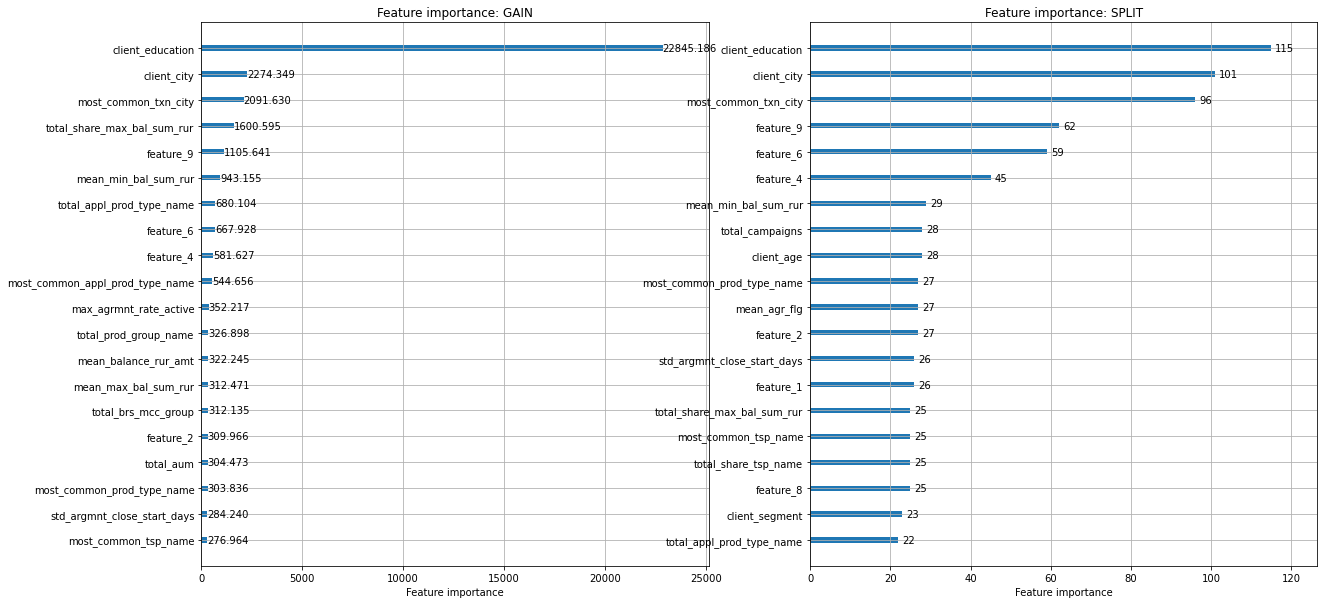

In [52]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
lightgbm.plot_importance(model, ax=ax[0], importance_type='gain', max_num_features=20, title='Feature importance: GAIN', ylabel='')
lightgbm.plot_importance(model, ax=ax[1], importance_type='split', max_num_features=20, title='Feature importance: SPLIT', ylabel='')
plt.show()

In [53]:
feature_importance = pd.DataFrame(np.array([list(X.columns),model.booster_.feature_importance(importance_type='gain')]).T)
feature_importance.columns = ['column', 'importance']
feature_importance['importance'] = feature_importance['importance'].map(float)
feature_importance.sort_values(by='importance', ascending = False).iloc[:30, 0].values

array(['client_education', 'client_city', 'most_common_txn_city',
       'total_share_max_bal_sum_rur', 'feature_9', 'mean_min_bal_sum_rur',
       'total_appl_prod_type_name', 'feature_6', 'feature_4',
       'most_common_appl_prod_type_name', 'max_agrmnt_rate_active',
       'total_prod_group_name', 'mean_balance_rur_amt',
       'mean_max_bal_sum_rur', 'total_brs_mcc_group', 'feature_2',
       'total_aum', 'most_common_prod_type_name',
       'std_argmnt_close_start_days', 'most_common_tsp_name',
       'mean_avg_bal_sum_rur', 'feature_1', 'client_age', 'mean_agr_flg',
       'feature_8', 'total_txn_comment_1', 'timedelta_payments_day_dt',
       'total_campaigns', 'mean_agrmnt_sum_rur', 'total_share_tsp_name'],
      dtype=object)

In [54]:
retrain_after_valid = False
if retrain_after_valid:
    running_train(X, Y, None, None, i_fold=-1, seed=4444)

In [55]:
if USE_WANDB:
    wandb.run.summary["validation_accuracy"] = validation_accuracy
    wandb.run.summary["anic"] = 1/3*public_score+ 2/3 * private_score

In [56]:
if make_submission:
    public_anic = float(input())
    wandb.run.summary["public_anic"] = public_anic

In [57]:
if USE_WANDB:
    run.finish()